# Procesamiento Digital de Audio
## Caleb Rascón
### Estimación de Múltiples Direcciones de Arribo
#### MUSIC Multi

In [1]:
#Bibliotecas
import numpy as np
from numpy import pi, sin
from numpy.fft import fft, ifft
from matplotlib import pyplot as plt


### Setup

In [2]:
doas = [-30, 40]    # Direction of arrival of both signals in degrees
d = 20              # Distance between microphones in meters
noise_w = 0.5       # Noise presence (between 0 and 1)
K = 200             # Signal size in samples, also frequency sampling

# Frequency vector
w = np.concatenate((np.arange(0,K//2 + 1), np.arange(-K//2 + 1, 0))) 

# Base frequency for signals
freq = [2, 4]

c = 343             # Speed of sound
fs = K              # Sampling frequency same as signal size (1 second)
t = np.arange(1, K + 1) / K  # Time vector (1 second)

N = 3               # Number of microphones
r = 2               # Number of signals in signal sub-space

# Original signals
s1 = sin(2 * pi * freq[0] * t)
s2 = sin(2 * pi * freq[1] * t)

s1_f = fft(s1)
s2_f = fft(s2)


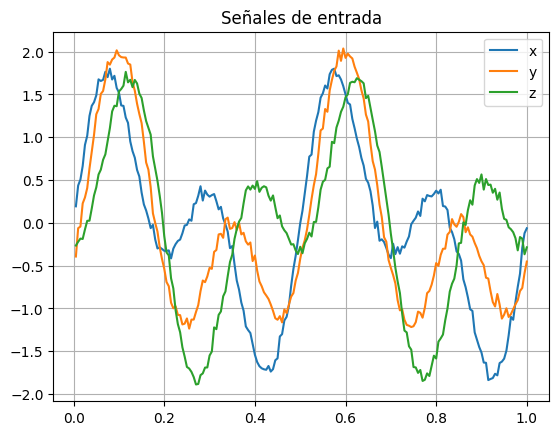

In [3]:
#Microphones
x = s1 + s2
y = ifft(fft(s1) * np.exp(-1j * 2 * pi * w * (d / c) * sin(doas[0] * pi / 180))).real + \
    ifft(fft(s2) * np.exp(-1j * 2 * pi * w * (d / c) * sin(doas[1] * pi / 180))).real
z = ifft(fft(s1) * np.exp(-1j * 2 * pi * w * (2 * d / c) * sin(doas[0] * pi / 180))).real + \
    ifft(fft(s2) * np.exp(-1j * 2 * pi * w * (2 * d / c) * sin(doas[1] * pi / 180))).real

# Adding noise
x += np.random.randn(K) * noise_w / 10
y += np.random.randn(K) * noise_w / 10
z += np.random.randn(K) * noise_w / 10

plt.plot(t,x, label='x')
plt.plot(t,y, label='y')
plt.plot(t,z, label='z')
plt.title('Señales de entrada')
plt.legend()
plt.grid()
plt.show()

In [4]:
#Data matrix with noise
X = np.array([fft(x), fft(y), fft(z)])

In [5]:
#Define angles to look for orthogonality
angles = np.arange(-90,90,.1)
music_spectrum = np.zeros((r,len(angles)))

#Normally, you should do the next step for each appropriate frequency
# we're only doing it in the frequencies that most closely fit s1's and s2's frequency

this_ws = [2, 4]

for f, this_w in enumerate(this_ws):
  this_X = X[:, this_w].reshape(N,1)
  #Covarianve matrix
  R = this_X @ this_X.T.conj() #This matrix should be calculated using past
                               # windows, but for now using only current window

  #Eigendecomposition of covarianve matrix
  #Q: vectors
  #D: values
  D, Q = np.linalg.eig(R)

  #Sorting eigenvalues (descending order)
  sort_index = np.argsort(-D)

  #Sorting eigenvectors
  Q = Q[:,sort_index]

  #Getting signal eigenvectors
  Qs = Q[:,:r]

  #Getting noise eigenvectors
  Qn = Q[:,r:N]

  #Compute the steering vectors corresponding to values in angles
  a1 = np.ones((N,len(angles)), dtype='complex')
  #First microphone is refrence, no delay
  #Second mic, delayed one instance
  a1[1,:] = np.exp( -1j*2*pi*w[this_w]*(d/c)*sin(angles*pi/180))
  #Third mic, delayed double distance
  a1[2,:] = np.exp( -1j*2*pi*w[this_w]*(2*d/c)*sin(angles*pi/180))

  #Compute MUSIC spectrum
  for k in range(len(angles)):
    music_spectrum[f,k] = np.abs( 1/(a1[:,k].T @ Qn @ Qn.T @ a1[:,k]) )

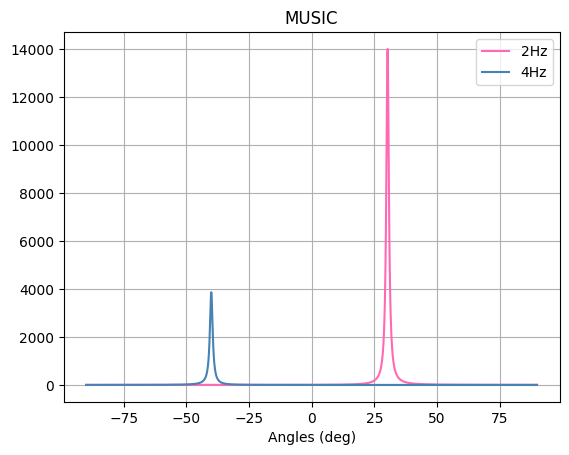

In [6]:
plt.plot(angles, music_spectrum[0], label='2Hz', color='hotpink')
plt.plot(angles, music_spectrum[1], label='4Hz', color='steelblue')
plt.legend()
plt.title('MUSIC')
plt.xlabel('Angles (deg)')
plt.grid()
plt.show()

In [7]:
for i, f in enumerate(freq):
  print(f'La señal de frecuencia {f} está en el ángulo {angles[np.argmax(music_spectrum[i])]:.2f}')

La señal de frecuencia 2 está en el ángulo 30.30
La señal de frecuencia 4 está en el ángulo -40.10


Por alguna razón al calcular esto en python, las DOA's están en el orden inverso